# Face Detection Comparison

Several face detection technique:
1. Haar Cascade Classifier
2. Dlib HOG
3. MTCNN

In [1]:
import os
import cv2 as cv
import dlib
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

/home/agusgun/anaconda3/envs/basic/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model_dir_path = 'model_data/'
CASCADE_CLASSIFIER_MODEL_PATH = os.path.join(model_dir_path, 'haarcascade_frontalface_alt.xml')

In [3]:
cascade_detector = cv.CascadeClassifier(CASCADE_CLASSIFIER_MODEL_PATH)
dlib_hog_detector = dlib.get_frontal_face_detector()
mtcnn_detector = MTCNN()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [4]:
# Not gray img, but RGB
gray_img = cv.cvtColor(cv.imread('../lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'), cv.COLOR_BGR2RGB)

## Haar Cascade Classifier

In [5]:
%%time
face_bboxes = cascade_detector.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5)

CPU times: user 88 ms, sys: 83.8 ms, total: 172 ms
Wall time: 135 ms


In [6]:
gray_img_copy = gray_img.copy()
for face in face_bboxes:
    x, y, w, h = face
    cv.rectangle(gray_img_copy, (x,y), (x+w, y+h), (0,255,0), 2)

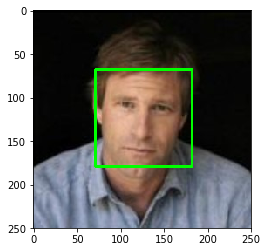

In [7]:
plt.imshow(gray_img_copy, cmap='gray')

## Dlib HOG

In [8]:
%%time
face_bboxes = dlib_hog_detector(gray_img, 1)

CPU times: user 36.3 ms, sys: 12 µs, total: 36.3 ms
Wall time: 36.2 ms


In [9]:
gray_img_copy = gray_img.copy()
for face in face_bboxes:
    x = face.left()
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y

    # draw box over face
    cv.rectangle(gray_img_copy, (x,y), (x+w,y+h), (0,255,0), 2)

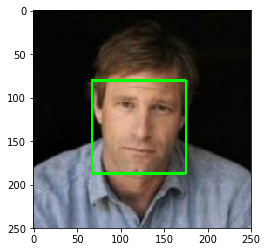

In [10]:
plt.imshow(gray_img_copy, cmap='gray')

## MTCNN

In [11]:
%%time
detection_result = mtcnn_detector.detect_faces(gray_img)    

CPU times: user 381 ms, sys: 400 ms, total: 781 ms
Wall time: 278 ms


In [12]:
gray_img_copy = gray_img.copy()
for face in detection_result:
    face_bbox = face['box']
    x, y, w, h = face_bbox
    
    cv.rectangle(gray_img_copy, (x,y), (x+w,y+h), (0,255,0), 2)

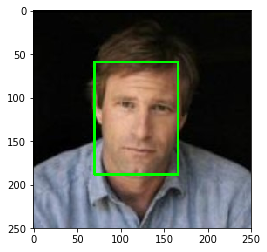

In [13]:
plt.imshow(gray_img_copy, cmap='gray')

## Compare Using Face Detection (Face Bio) Dataset

In [14]:
DIR_PATH = '../BioID-FaceDatabase-V1.2/'
image_path_list = []
eye_path_list = []
for root, dirs, files in os.walk(DIR_PATH):
    for filename in files:
        file_path = os.path.join(root, filename)
        if filename.split('.')[1] == 'pgm':
            image_path_list.append(file_path)
        elif filename.split('.')[1] == 'eye':
            eye_path_list.append(file_path)

In [15]:
image_path_list.sort()
eye_path_list.sort()

In [16]:
eye_position_list = []
for file_path in eye_path_list:
    with open(file_path, 'r') as file:
        eye_position = list(map(int, file.readlines()[1].split()))
        eye_position_list.append(eye_position)

In [17]:
def check_true(eye_position, x, y, w, h):
    # Check X
    if eye_position[0] >= x and eye_position[0] <= x+w and eye_position[2] >= x and eye_position[2] <= x+w:
        if eye_position[1] >= y and eye_position[1] <= y+h and eye_position[3] >= y and eye_position[3] <= y+h:
            return True
    return False

In [18]:
TRUE_RESULT = len(image_path_list)

## First Detection

### Cascade Classifier

In [19]:
%%time
cascade_detector_result = 0
for idx, img_path in enumerate(image_path_list):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    face_bboxes = cascade_detector.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    if len(face_bboxes) > 0:
        x, y, w, h = face_bboxes[0]
        
        if check_true(eye_position_list[idx], x, y, w, h):
            cascade_detector_result += 1

CPU times: user 3min 16s, sys: 173 ms, total: 3min 16s
Wall time: 1min 41s


In [20]:
print(cascade_detector_result)

1443


### Dlib HOG

In [21]:
%%time
dlib_hog_result = 0
for idx, img_path in enumerate(image_path_list):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    face_bboxes = dlib_hog_detector(img, 1)
    for face in face_bboxes:
        x = face.left()
        y = face.top()
        w = face.right() - x
        h = face.bottom() - y 
        if check_true(eye_position_list[idx], x, y, w, h):
            dlib_hog_result += 1
        break

CPU times: user 1min 38s, sys: 91.1 ms, total: 1min 38s
Wall time: 1min 33s


In [22]:
print(dlib_hog_result)

1511


### MTCNN

In [23]:
%%time
mtcnn_result = 0
for idx, img_path in enumerate(image_path_list):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    detection_result = mtcnn_detector.detect_faces(img)
    for face in detection_result:
        face_bbox = face['box']
        x, y, w, h = face_bbox
        if check_true(eye_position_list[idx], x, y, w, h):
            mtcnn_result += 1
        break

CPU times: user 6min 52s, sys: 7min 18s, total: 14min 10s
Wall time: 2min 17s


In [24]:
print(mtcnn_result)

1512


## All Detection

### Cascade Classifier

In [25]:
%%time
cascade_detector_result = 0
for idx, img_path in enumerate(image_path_list):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    face_bboxes = cascade_detector.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    for face in face_bboxes:
        x, y, w, h = face

        if check_true(eye_position_list[idx], x, y, w, h):
            cascade_detector_result += 1

CPU times: user 3min 5s, sys: 91.3 ms, total: 3min 5s
Wall time: 1min 35s


In [26]:
print(cascade_detector_result)

1444


### Dlib HOG

In [27]:
%%time
dlib_hog_result = 0
for idx, img_path in enumerate(image_path_list):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    face_bboxes = dlib_hog_detector(img, 1)
    for face in face_bboxes:
        x = face.left()
        y = face.top()
        w = face.right() - x
        h = face.bottom() - y 
        if check_true(eye_position_list[idx], x, y, w, h):
            dlib_hog_result += 1

CPU times: user 1min 30s, sys: 33.3 ms, total: 1min 30s
Wall time: 1min 25s


In [28]:
print(dlib_hog_result)

1511


### MTCNN

In [29]:
%%time
mtcnn_result = 0
for idx, img_path in enumerate(image_path_list):
    img = cv.cvtColor(cv.imread(img_path), cv.COLOR_BGR2RGB)
    detection_result = mtcnn_detector.detect_faces(img)
    for face in detection_result:
        face_bbox = face['box']
        x, y, w, h = face_bbox
        if check_true(eye_position_list[idx], x, y, w, h):
            mtcnn_result += 1

CPU times: user 6min 43s, sys: 7min 26s, total: 14min 9s
Wall time: 2min 18s


In [30]:
print(mtcnn_result)

1512
